In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scvi
import scanpy as sc
import re
from scipy import sparse

sys.path = sys.path + ["/well/immune-rep/users/vbw431/Projects/Fairfax/utils/"]
import nested_clustering


Global seed set to 0
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
##set dirs
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"
clus_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/clustering/"

In [3]:
#load data
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/Peppa_azimuth_SCVI.h5ad")



In [4]:
##Normalise
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)



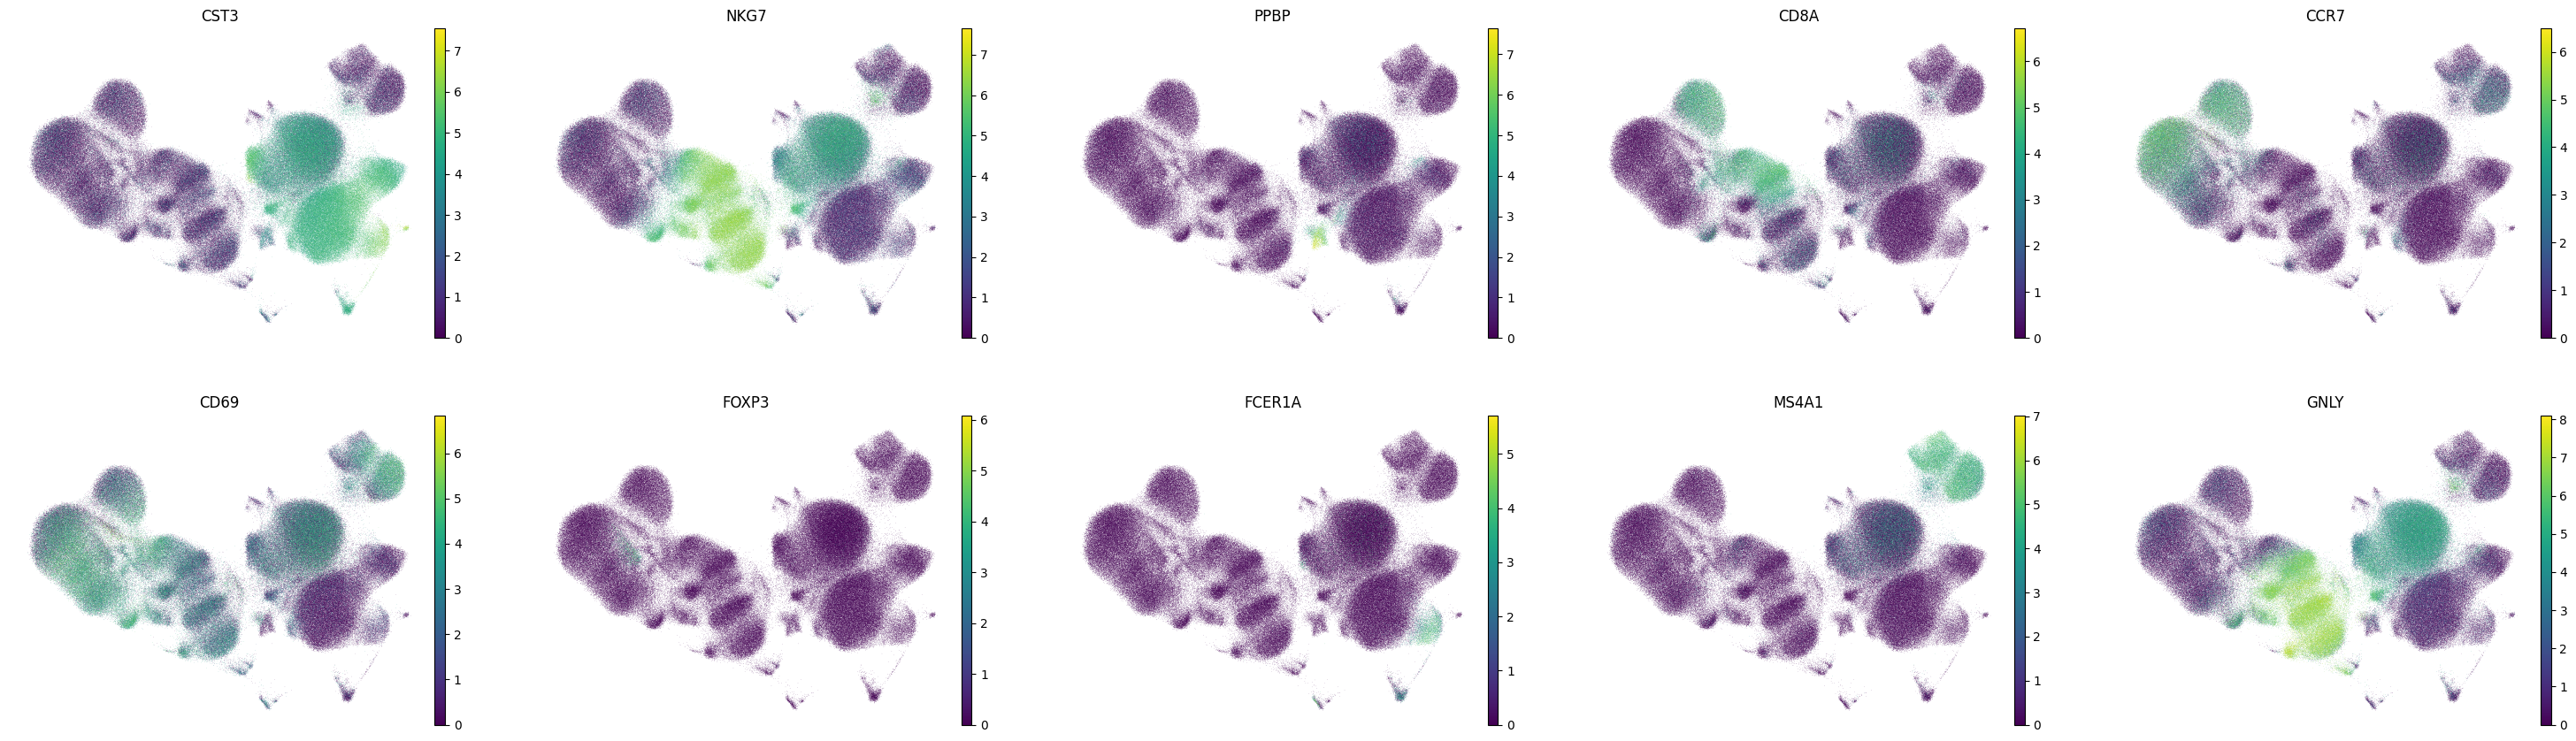

<Figure size 640x480 with 0 Axes>

In [5]:
#plot umap
with plt.rc_context():  # Use this to set figure params like size and dpi
  sc.pl.umap(
    adata,
    color=['CST3', 'NKG7', 'PPBP', 'CD8A','CCR7','CD69','FOXP3',"FCER1A", "MS4A1","GNLY"],
    frameon=False,
    ncols=5,
    #     size=5,
  )
  plt.savefig(plot_dir+"SCVI_peppa_azimuth_markers.png", bbox_inches="tight")



In [6]:
import celltypist

adata_all = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)
##predict celltypes with celltypist

predictions = celltypist.annotate(adata_all, model = 'Immune_All_Low.pkl', majority_voting = True, mode = 'prob match', p_thres = 0.5)

adata_celltypist = predictions.to_adata(insert_conf = True)



In [7]:
#plot umap

with plt.rc_context():
    sc.pl.umap(adata_celltypist, 
               color = ['majority_voting'],
               ncols=1
              )
    plt.savefig(plot_dir+"SCVI_peppa_azimuth_umap_knn_celltypist_label.png", bbox_inches="tight")



KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
adata.obs = adata_celltypist.obs.copy()

set(adata.obs)

In [ ]:
##save adata
adata.write("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat_clus.h5ad")


In [ ]:
##perform nested clustering - code credit: https://github.com/LungCellAtlas/HLCA_reproducibility/tree/main/scripts

##set params
dataset_name = "scvi"

##HCA atlas clustering method
number_of_clust_levels = 2
use_rep = "X_scVI"


In [ ]:
for clustering_level in range(1, number_of_clust_levels + 1):
    print("clustering level:", clustering_level, "...")
    if clustering_level == 1:
        # skip for re-run
        cluster_name = "leiden_1"
        # first clustering is not nested, so use normal function:
        sc.pp.neighbors(adata, n_neighbors=30, use_rep=use_rep)
        sc.tl.leiden(adata, resolution=0.05, key_added=cluster_name)
    else:
        previous_clustering = "leiden_" + str(clustering_level - 1)
        cluster_name = "leiden_" + str(clustering_level)
        #         perform nested clustering
        #         set parameters:
        res = 0.2
        if clustering_level == 2:
            k = 30
            min_cluster_size = 50
        elif clustering_level == 3:
            k = 15
            min_cluster_size = 30
        elif clustering_level == 4:
            k = 10
            min_cluster_size = 10
        adata = nested_clustering.add_nested_clustering_blind(
            adata,
            previous_clustering,
            cluster_name,
            use_rep=use_rep,
            cluster_alg="leiden",
            cluster_k=k,
            cluster_res=res,
            min_cluster_size=min_cluster_size,
            redo_pca=False,  # SET THIS TO FALSE FOR SCANVI!!! OR OTHER EMBEDDING-OUTPUT METHODS!!!!!
          )
    # plot
    if "X_umap" in adata.obsm.keys():
        with plt.rc_context():
          sc.pl.umap(adata, color=cluster_name, frameon=False,ncols=1, title=cluster_name, legend_loc='on data')
          plt.savefig(plot_dir+"SCVI_dann_map_umap_"+cluster_name+".png", bbox_inches="tight")
    # store clustering:
    cluster_df = pd.DataFrame(adata.obs[cluster_name], index=adata.obs.index)
    # write to csv for benchmarking data:
    if dataset_name == "scvi":
        # store cluster assignments:
        cluster_df.to_csv(
            os.path.join(clus_dir, f"Peppa_{cluster_name}_cluster_assignment.csv")
        )
        # calculate marker genes with respect to all other clusters, and with respect to sister clusters (i.e. other cluster from the same parent cluster):
        for marker_ref in ["sisters", "all"]:
            marker_gene_df = nested_clustering.get_cluster_markers(
                adata=adata,
                cluster_label=cluster_name,
                marker_ref=marker_ref,
                ngenes=100,
            )
            # and store:
            marker_gene_df.to_csv(
                os.path.join(clus_dir, f"Peppa_{cluster_name}_marker_genes_versus_{marker_ref}.csv")
            )





<Figure size 640x480 with 0 Axes>

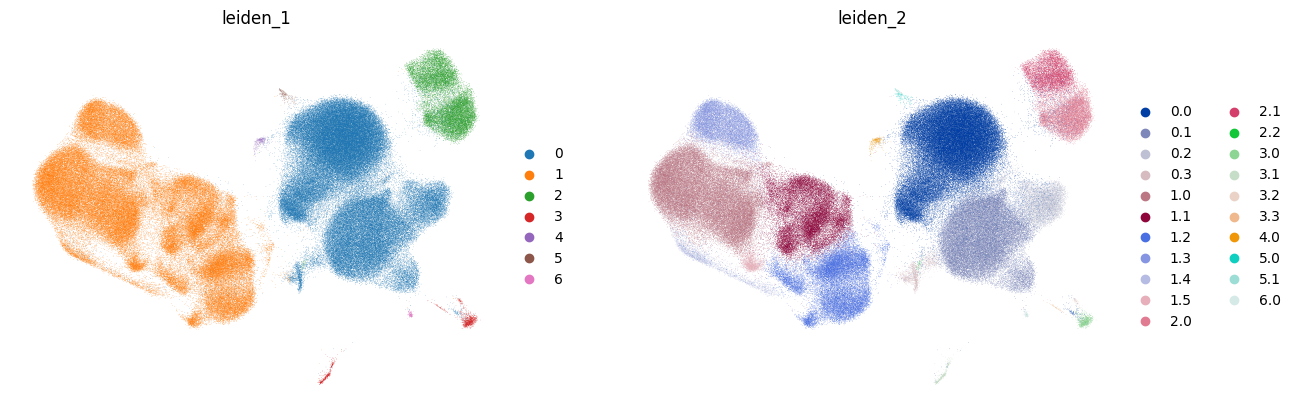

In [12]:
##Check leiden vs new clus
leiden_clus = [col for col in adata.obs.columns if 'leiden' in col]

##plot
with plt.rc_context():
    sc.pl.umap(
        adata,
        color=leiden_clus,
        frameon=False,
        #legend_loc='on data',
    )
    plt.savefig(plot_dir+"SCVI_peppa_azimuth_leiden_iter.png", bbox_inches="tight")


In [14]:
##save adata
adata.write("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat_clus.h5ad")


In [4]:
#adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat_clus.h5ad")

In [16]:
set(adata.obs["Pool_ID"])
set(adata.obs["orig.ident"])
set(adata.obs["scvi_batch"])

{'HBV_C',
 'HBV_Tre_1',
 'HBV_Tre_2',
 'HBV_Tre_3',
 'HBV_X2',
 'HH_Tre_4',
 'HIVHBV_C',
 'HIVHBV_Tre_5',
 'HIVHBV_X2',
 'Healthy',
 'P1_0',
 'P2_0',
 'P4_0',
 'P5_0',
 'P8_0'}

/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


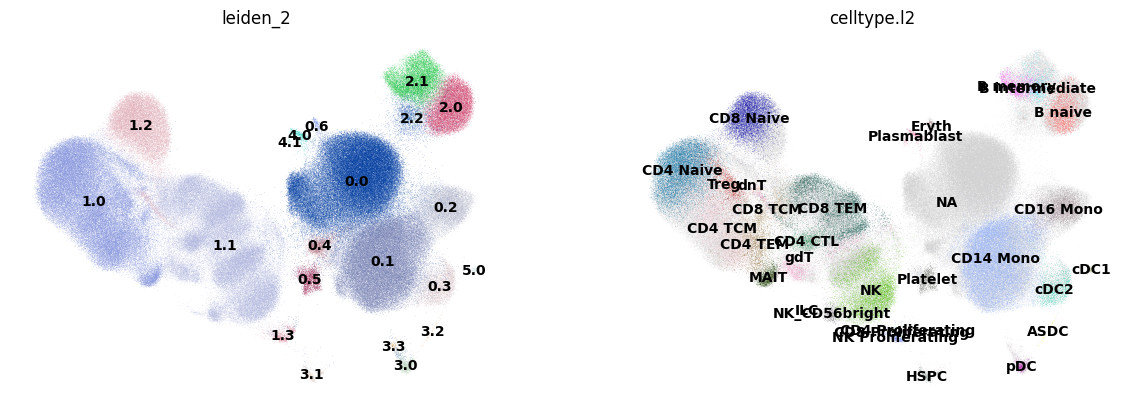

In [5]:
sc.pl.umap(
        adata,
        color=["leiden_2", "celltype.l2"],
        frameon=False,
        legend_loc='on data',
    )

In [6]:
TNK = adata[adata.obs["leiden_2"].isin(['1.1','1.2','1.0','1.5','1.3'])].copy()
Bcells = adata[adata.obs["leiden_2"].isin(['2.0','2.1','4.0'])].copy()
Myeloid_Plt = adata[adata.obs["leiden_2"].isin(['0.1', '0.2','3.1','0.3','3.2','3.3','3.0'])].copy()

In [7]:
adata_list = {'TNK': TNK, 'Bcells': Bcells, 'Myeloid_Plt': Myeloid_Plt}


In [9]:
for name, value in adata_list.items():
    print('calculating neighbours for ', name)
    sc.pp.neighbors(adata_list[name], n_neighbors=30, use_rep="X_scVI", metric="cosine")    
    
    print('calculating umap for ', name)
    sc.tl.umap(adata_list[name])


calculating neighbours for  TNK
calculating umap for  TNK
calculating neighbours for  Bcells
calculating umap for  Bcells
calculating neighbours for  Myeloid_Plt
calculating umap for  Myeloid_Plt


plotting leiden clusters for  TNK


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


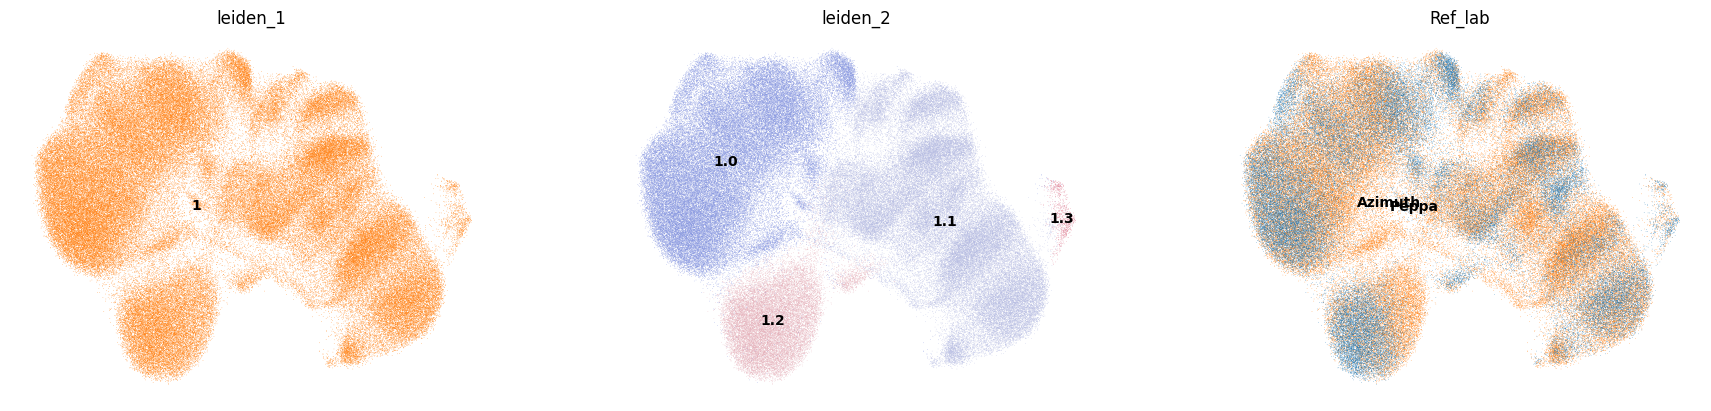

plotting leiden clusters for  Bcells


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

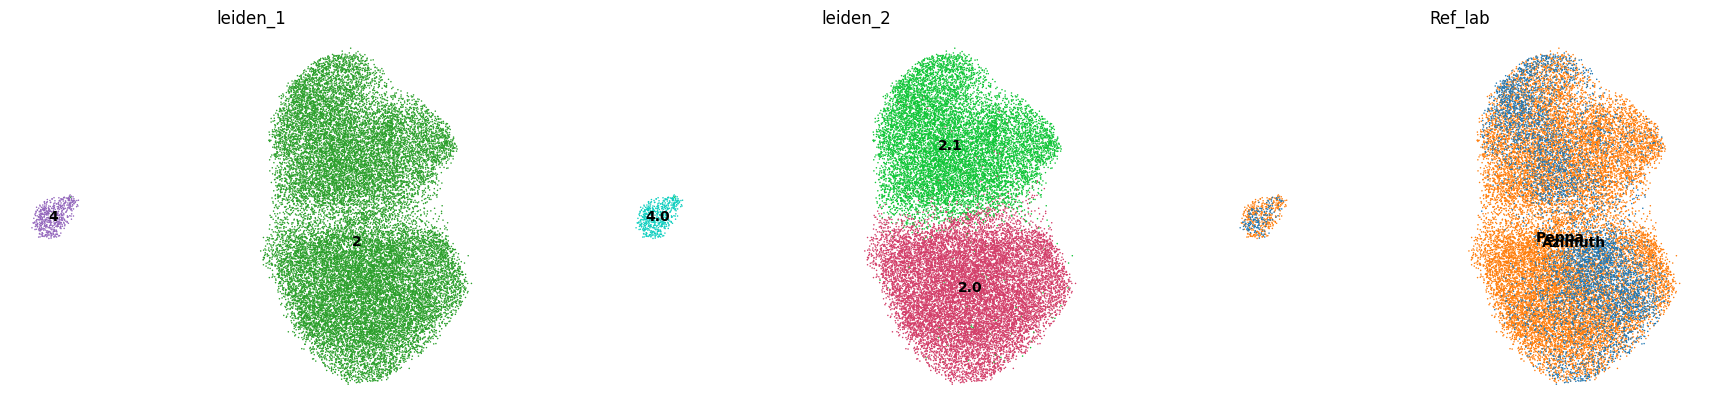

plotting leiden clusters for  Myeloid_Plt


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 640x480 with 0 Axes>

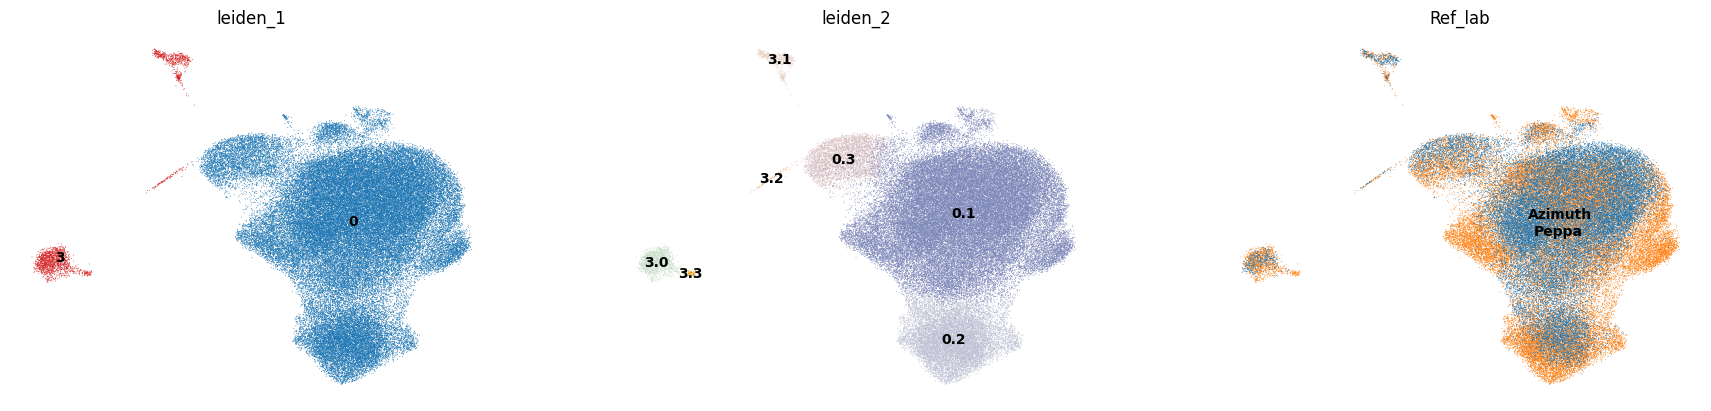

<Figure size 640x480 with 0 Axes>

In [10]:
for name, value in adata_list.items():
    print('plotting leiden clusters for ', name)
    ##Check leiden vs new clus
    leiden_clus = [col for col in adata_list[name].obs.columns if 'leiden' in col]
    leiden_clus.append("Ref_lab")
    with plt.rc_context():
        sc.pl.umap(
            adata_list[name],
            color=leiden_clus,
            frameon=False,
            title=leiden_clus,
            legend_loc='on data',
        )
        plt.savefig(plot_dir+"SCVI_peppa_azimuth_"+name+"_leiden.png", bbox_inches="tight")


/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/python/scvi_new-ivybridge/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/gpfs2/well/immune-rep/users/vbw431/

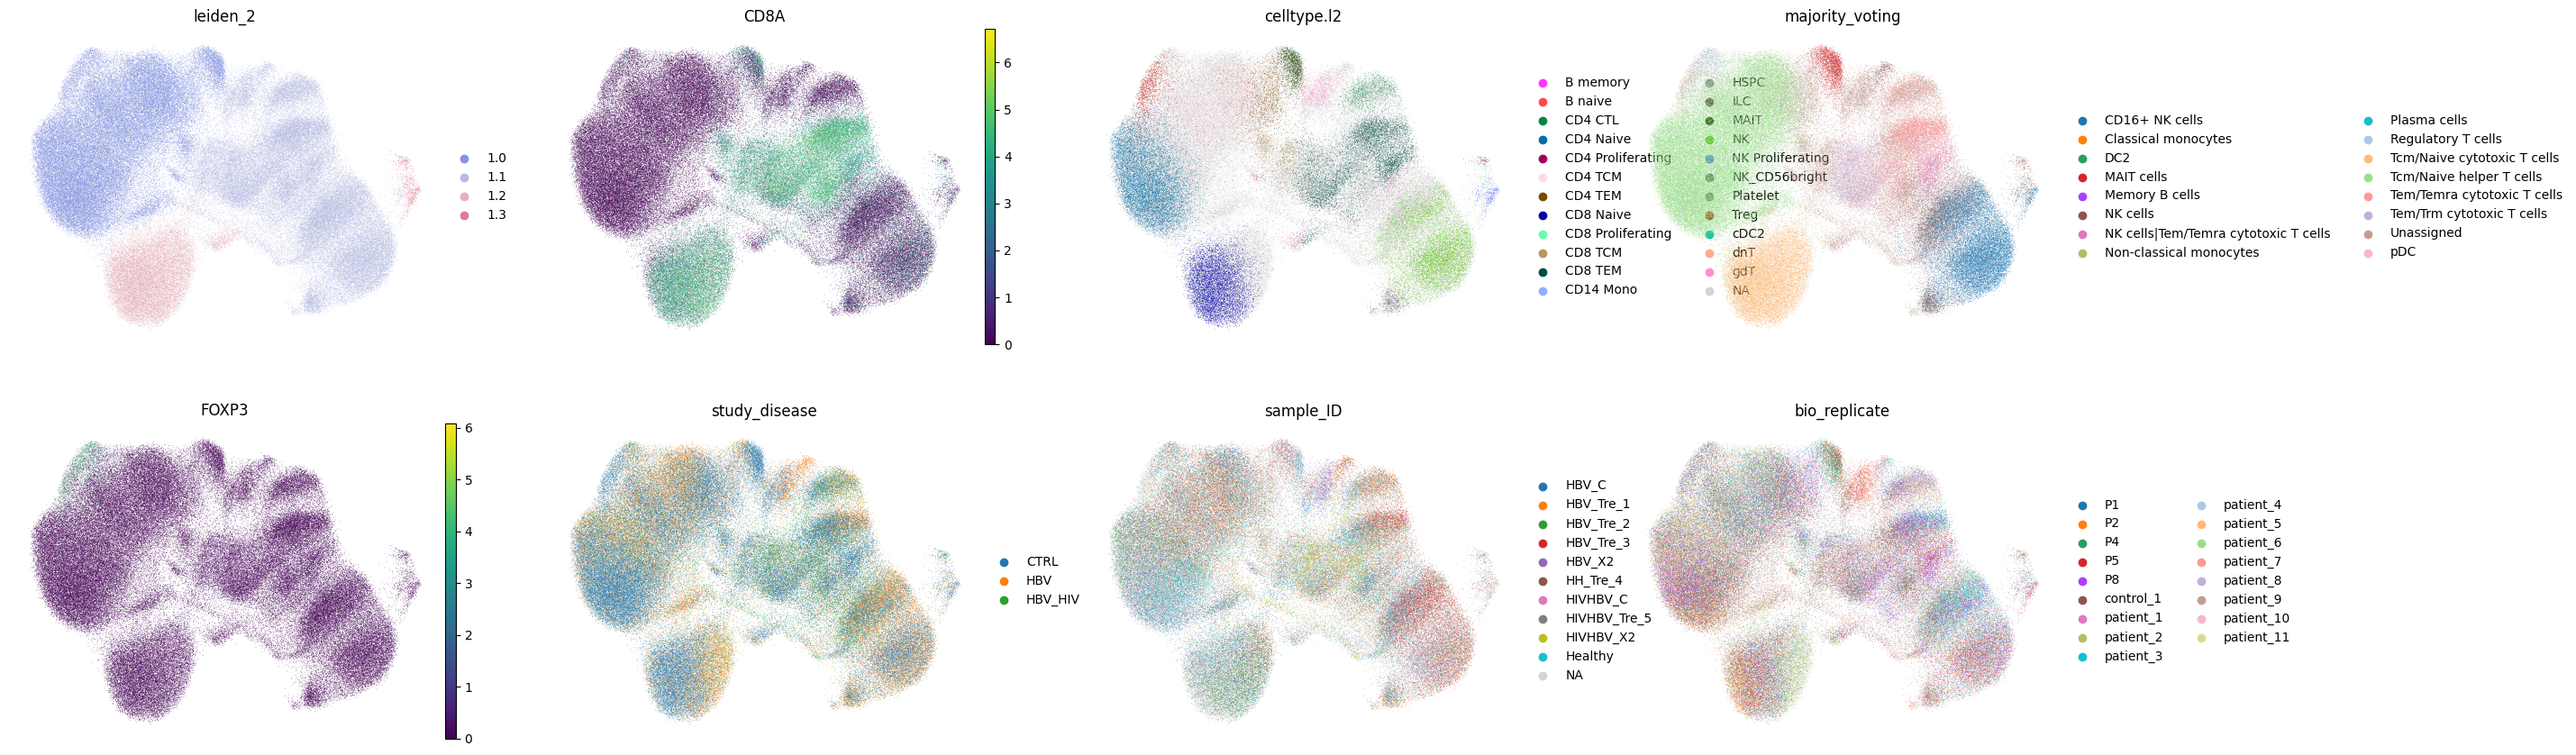

<Figure size 640x480 with 0 Axes>

In [11]:
##explore TNK to identify high confident NK
with plt.rc_context():
    sc.pl.umap(
        adata_list["TNK"],
        color=["leiden_2", "CD8A", "celltype.l2","majority_voting", "FOXP3", "study_disease", "sample_ID", "bio_replicate"],
        frameon=False,
       # legend_loc='on data',
    )
    plt.savefig(plot_dir+"SCVI_peppa_azimuth_"+name+"_leiden.png", bbox_inches="tight")


In [13]:
##save subclusters
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"

#CD8NK.write(data_dir + "CD8NK.h5ad")
#CD4.write(data_dir + "CD4.h5ad")
adata_list["Bcells"].write(data_dir + "Bcells.h5ad")
adata_list["Myeloid_Plt"].write(data_dir + "Myeloid_Plt.h5ad")
adata_list["TNK"].write(data_dir + "TNK.h5ad")
